In [1]:
import os
import requests
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.decomposition import PCA
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import json

In [2]:
def cosine_similarity(a, b):
    na = a / torch.norm(a)
    nb = b / torch.norm(b)
    
    return torch.dot(na, nb).cpu().item()

In [3]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [5]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    text="A red ball",
    images=image, return_tensors="pt", padding=True).to(device)
inputs["output_hidden_states"] = True
outputs_text_and_image = model(**inputs)

In [6]:
outputs_text_and_image.text_embeds.size()

torch.Size([1, 512])

In [40]:
def image_from_url(url):
    image = Image.open(requests.get(url, stream=True).raw)
    
    return image


def image_similarity(image_a, image_b):
    inputs = processor(
        text=None,
        images=[image_a, image_b], return_tensors="pt", padding=True).to(device)
    outputs_image_only = model.get_image_features(**inputs)
    
    a = outputs_image_only[0,:]
    b = outputs_image_only[1,:]
    
    return cosine_similarity(a, b)


def text_similarity(text_a, text_b):
    inputs = processor(
        text=[text_a, text_b],
        images=None, return_tensors="pt", padding=True).to(device)
    outputs_text_only = model.get_text_features(**inputs)

    a = outputs_text_only[0,:]
    b = outputs_text_only[1,:]
    
    return cosine_similarity(a, b)


def text_image_similarity(text_a, image_b):
    inputs = processor(
        text=text_a,
        images=image_b, return_tensors="pt", padding=True).to(device)
    outputs_text_and_image = model(**inputs)
    image_embed = outputs_text_and_image.image_embeds[0,:]
    text_embed = outputs_text_and_image.text_embeds[0,:]
    
    return cosine_similarity(image_embed, text_embed)

In [8]:
sitting_man_1_url = "https://st2.depositphotos.com/1017833/7218/i/950/depositphotos_72182671-stock-photo-black-man-sitting-on-floor.jpg"
sitting_man_2_url = "https://st2.depositphotos.com/3332767/10230/i/950/depositphotos_102308414-stock-photo-young-cheerful-man-sitting-on.jpg"

standing_man_1_url = "https://media.istockphoto.com/id/183765770/photo/casual-man-side-view.jpg?s=612x612&w=0&k=20&c=na2fe7RHVC5h8t4Tc9WUxHcpj6c4gN1WySssj9lkm4s="
standing_man_2_url = "https://as2.ftcdn.net/v2/jpg/01/08/54/59/1000_F_108545948_hboYGnkUU57d5YQC3LSMm0bp26jvyclV.jpg"


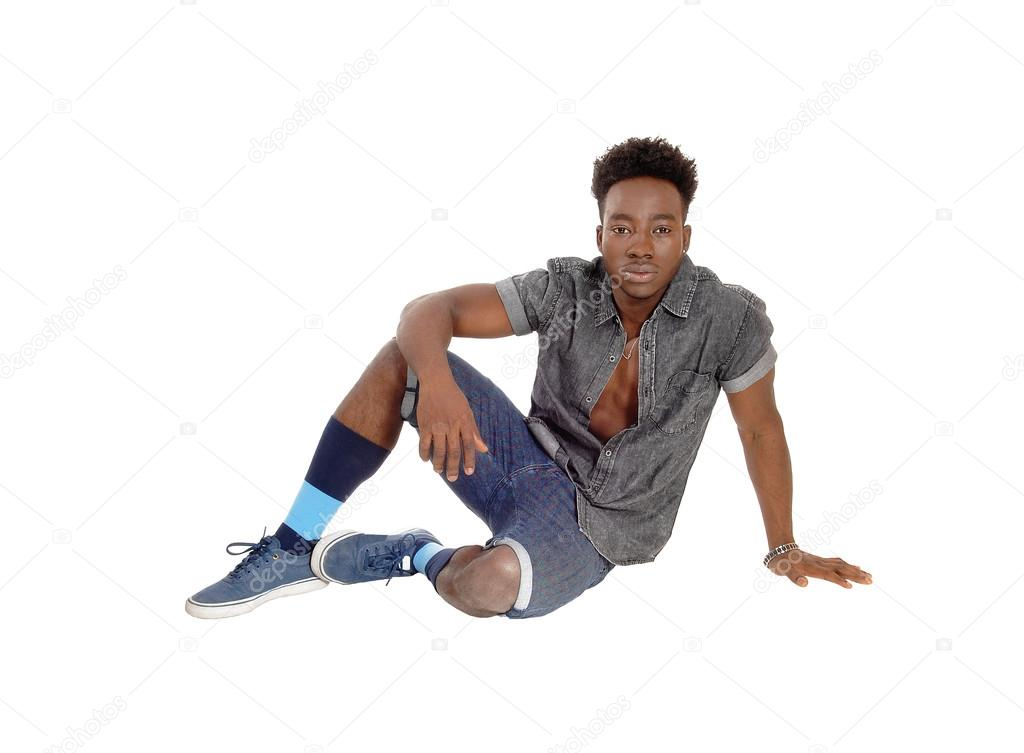

In [9]:
image_from_url(sitting_man_1_url)

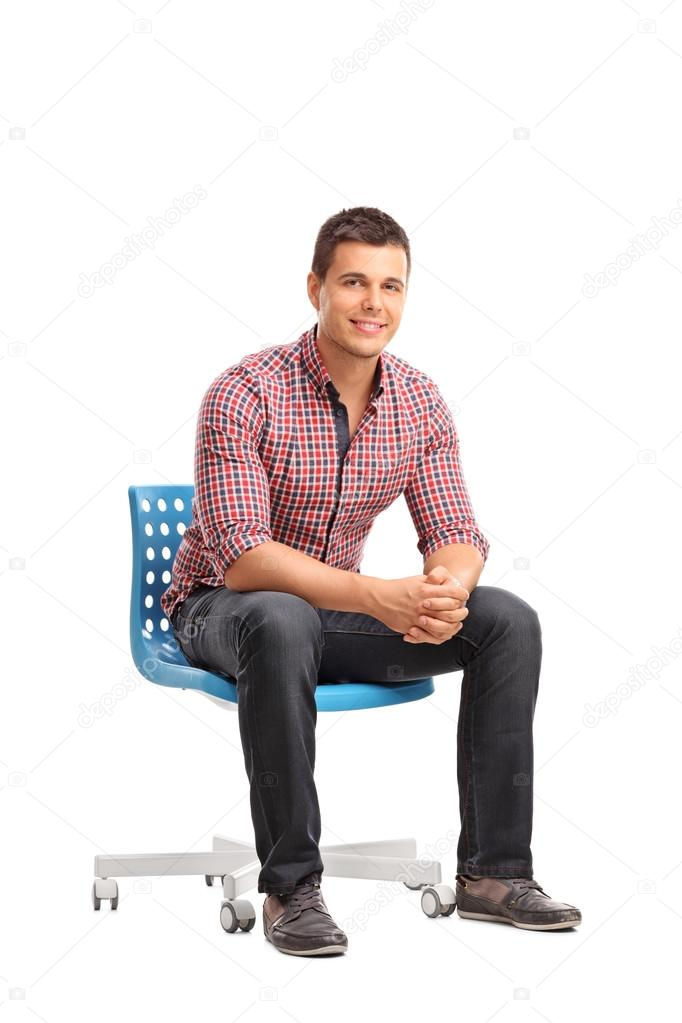

In [10]:
image_from_url(sitting_man_2_url)

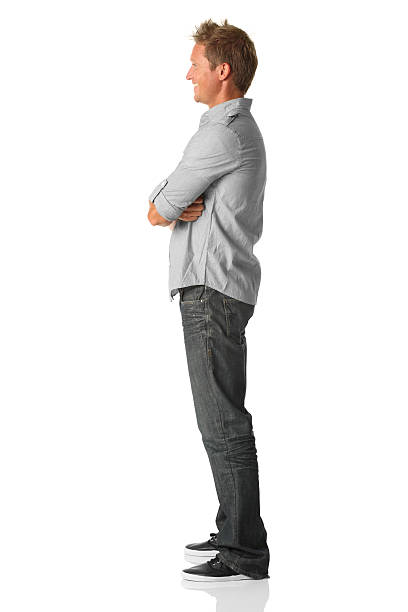

In [11]:
image_from_url(standing_man_1_url)

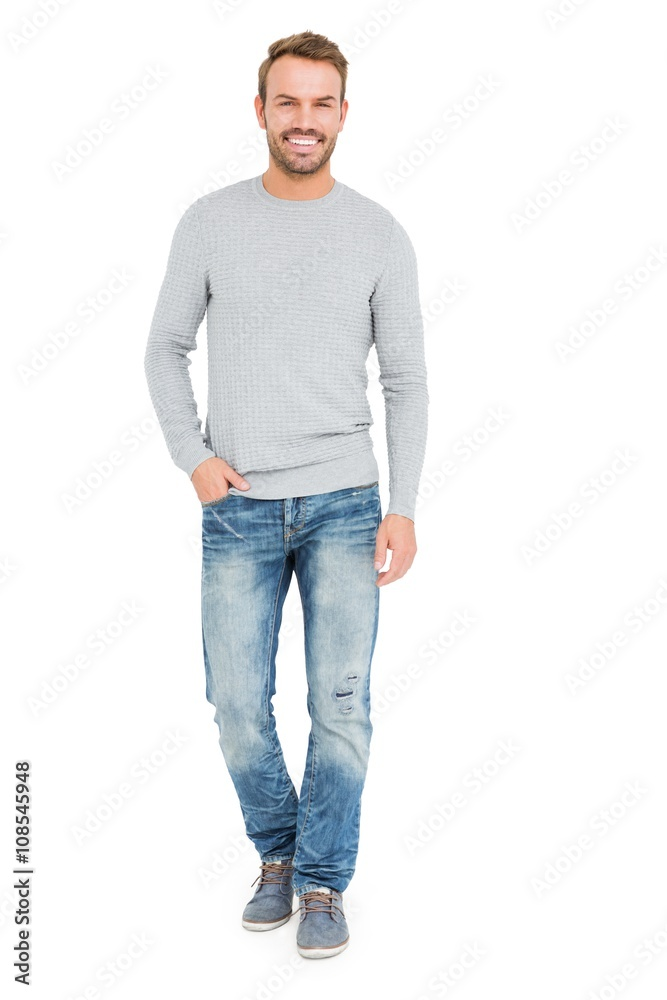

In [12]:
image_from_url(standing_man_2_url)

In [13]:
image_similarity(image_from_url(standing_man_1_url), image_from_url(standing_man_1_url))

1.0

In [14]:
image_similarity(image_from_url(standing_man_1_url), image_from_url(standing_man_2_url))

0.8046651482582092

In [15]:
image_similarity(image_from_url(standing_man_1_url), image_from_url(sitting_man_1_url))

0.6686322093009949

In [16]:
image_similarity(image_from_url(standing_man_1_url), image_from_url(sitting_man_2_url))

0.7178568840026855

In [17]:
image_similarity(image_from_url(sitting_man_1_url), image_from_url(sitting_man_2_url))

0.7584884166717529

In [29]:
text_similarity("A ball", "A red ball")

0.9167959690093994

In [30]:
text_similarity("A ball", "A red bench")

0.6863992810249329

In [45]:
text_similarity("A man standing", "A man sitting")

0.8705783486366272

In [41]:
text_image_similarity("A man standing", image_from_url(standing_man_1_url))

0.2733045518398285

In [46]:
text_image_similarity("A man standing on the floor, wearing jeans and looking to the left", image_from_url(standing_man_1_url))

0.3118040859699249

In [47]:
text_image_similarity(
    "A man standing on the floor, wearing jeans and looking to the left",
    image_from_url(sitting_man_1_url))

0.23272579908370972

In [42]:
text_image_similarity("A man sitting", image_from_url(standing_man_1_url))

0.25692251324653625

In [43]:
text_image_similarity("A man sitting", image_from_url(sitting_man_1_url))

0.28559017181396484

In [44]:
text_image_similarity("A man standing", image_from_url(sitting_man_1_url))

0.25209349393844604

In [18]:
def load_video_frames_from(video_frames_folder):
    images = []
    for image_filename in sorted(os.listdir(video_frames_folder)):
        image_filepath = f"{video_frames_folder}/{image_filename}"
        image = Image.open(image_filepath)
        images.append(image)

    return images

In [19]:
def principal_projections(image_embeddings, principal_direction, normalize_embeddings=False):
    u = principal_direction / torch.norm(principal_direction)
    projections = []
    n, _ = image_embeddings.size()
    for i in range(n):
        if normalize_embeddings:
            projections.append(torch.dot(image_embeddings[i,:].detach() / torch.norm(image_embeddings[i,:].detach()), u).cpu().item())
        else:
            projections.append(torch.dot(image_embeddings[i,:].detach(), u).cpu().item())
    
    return projections

In [20]:
def process_video_frames(file_path):
    images = load_video_frames_from(file_path)
    try:
        inputs = processor(
            text=None,
            images=images, return_tensors="pt", padding=True).to(device)
        outputs_image_only = model.get_image_features(**inputs)
        mean = torch.mean(outputs_image_only, 0)
        pairwise_differences = []
        for i in range(len(images)):
            for j in range(len(images)):
                if i != j:
                    diff = (outputs_image_only[i,:] - outputs_image_only[j,:]).detach().cpu().numpy()
                    pairwise_differences.append(diff)

        A = torch.Tensor(np.array(pairwise_differences)).to(device)
        U, S, Vh = torch.linalg.svd(A, full_matrices=True)
        singular_values = S.cpu().tolist()
        principal_component = (Vh[0,:].detach() / torch.norm(Vh[0,:].detach()))
        projections = principal_projections(outputs_image_only.detach(), principal_component)
        result = {
            "gif_frames_path": file_path,
            "principal_component": principal_component.cpu().tolist(),
            "singular_values": singular_values,
            "image_embeddings_sequential": outputs_image_only.detach().cpu().tolist(),
            "image_embeddings_sequential_projections": projections,
            "processing_error": False
        }

    except:
        result = {
            "gif_frames_path": file_path,
            "processing_error": True
        }

    return result


def plot_singular_values(singular_values, max_bars=20):
    num_bars = min(len(singular_values), max_bars)
    plt.bar(list(range(num_bars)), singular_values[:num_bars])


def plot_projections(projections):
    plt.plot(projections, marker='o')


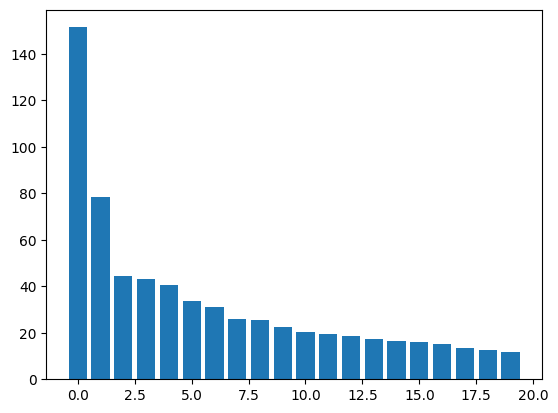

In [21]:
result = process_video_frames("datasets/images/blocks-frames")
plot_singular_values(result["singular_values"])

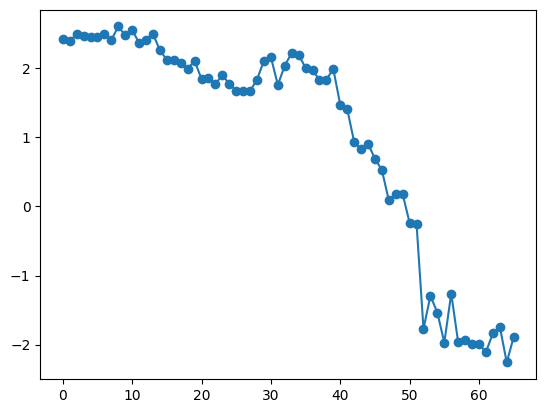

In [22]:
plot_projections(result["image_embeddings_sequential_projections"])

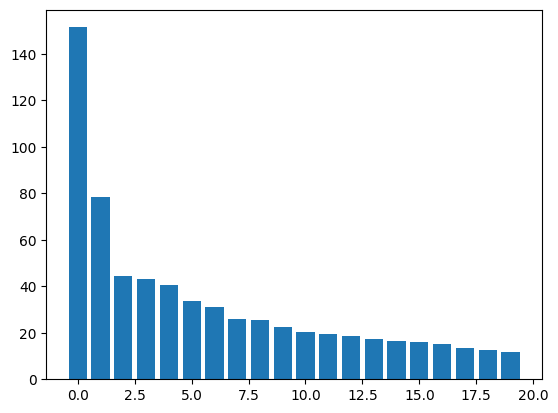

In [23]:
images = load_video_frames_from("datasets/images/blocks-frames")
inputs = processor(
    text=None,
    images=images, return_tensors="pt", padding=True).to(device)
outputs_image_only = model.get_image_features(**inputs)
pairwise_differences = []
for i in range(66):
    for j in range(66):
        if i != j:
            diff = (outputs_image_only[i,:] - outputs_image_only[j,:]).detach().cpu().numpy()
            pairwise_differences.append(diff)

A = torch.Tensor(np.array(pairwise_differences)).to(device)
U, S, Vh = torch.linalg.svd(A, full_matrices=True)
singular_values = S.cpu().numpy()
# num_bars = len(singular_values)
# plt.bar(list(range(min(num_bars, 20))), singular_values[:20])
plot_singular_values(singular_values)

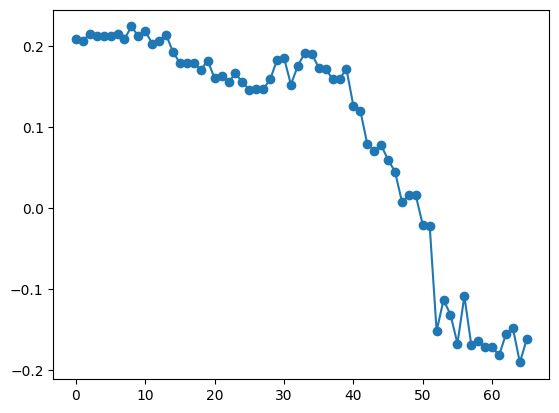

In [24]:
projections = principal_projections(outputs_image_only, principal_direction = Vh[0,:].detach(), normalize_embeddings=True)
plt.plot(projections, marker='o')

<BarContainer object of 20 artists>

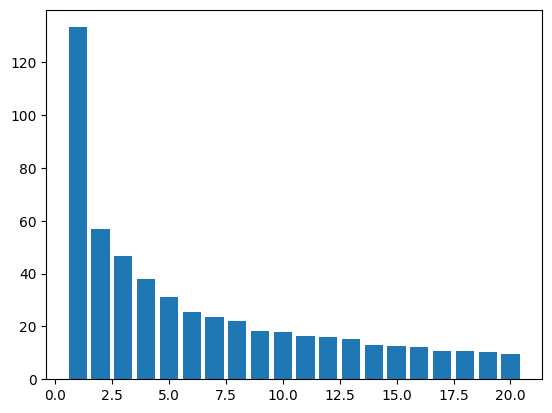

In [25]:
images = load_video_frames_from("datasets/images/rolling-ball")
inputs = processor(
    text=None,
    images=images, return_tensors="pt", padding=True).to(device)
outputs_image_only = model.get_image_features(**inputs)
pairwise_differences = []
for i in range(len(images)):
    for j in range(len(images)):
        if i != j:
            diff = (outputs_image_only[i,:] - outputs_image_only[j,:]).detach().cpu().numpy()
            pairwise_differences.append(diff)

A = torch.Tensor(np.array(pairwise_differences)).to(device)
U, S, Vh = torch.linalg.svd(A, full_matrices=True)
singular_values = S.cpu().numpy()
plt.bar(list(range(1, 21)), singular_values[:20])

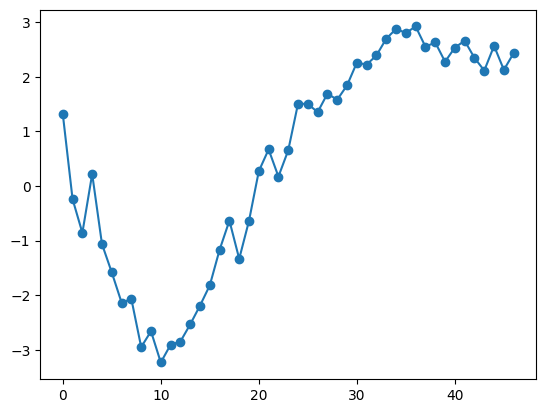

In [26]:
projections = principal_projections(outputs_image_only, principal_direction = Vh[0,:].detach())
plt.plot(projections, marker='o')

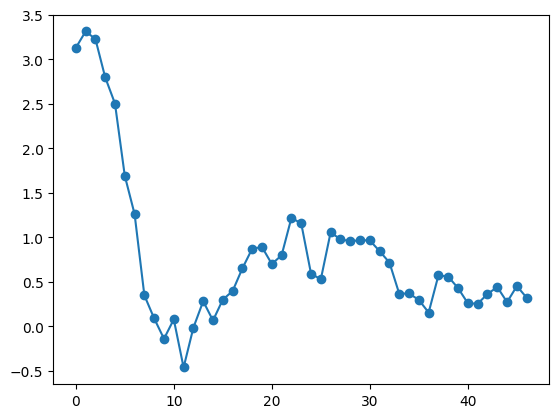

In [27]:
projections = principal_projections(outputs_image_only, principal_direction = Vh[1,:].detach())
plt.plot(projections, marker='o')